![](https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/se04.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLDiego/uom_fse_dl_workshop/blob/main/solutions/SE04_SL_Convolutional_Neural_Networks.ipynb)

## Workshop Overview
***
In this workshop, we explore Convolutional Neural Networks (CNNs) for computer vision tasks. Starting from the convolution operation itself, we build toward full CNN architectures for industrial image classification using the NEU-CLS surface defect dataset.

**Prerequisites**: Neural networks (SE02), PyTorch fundamentals (SE01)

**Learning Objectives**:
- Understand the convolution operation and its key parameters
- Apply and design convolutional filters for feature extraction
- Prepare image datasets using torchvision transforms and DataLoaders
- Build CNN architectures from scratch with PyTorch
- Train and evaluate CNNs on a real industrial classification task
- Implement MobileNet with depthwise separable convolutions

In [65]:
import sys
import subprocess

if "google.colab" in sys.modules:
    print("Running in Google Colab: downloading utils...")
    subprocess.run([
        "wget",
        "-q",
        "--show-progress",
        "https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/colab_utils.txt",
        "-O",
        "colab_utils.txt",
    ], check=True)
    subprocess.run([
        "wget",
        "-q",
        "--show-progress",
        "-x",
        "-nH",
        "--cut-dirs=3",
        "-i",
        "colab_utils.txt",
    ], check=True)
else:
    print("Running locally: skipping Colab utils download.")

Running locally: skipping Colab utils download.


In [66]:
from pathlib import Path
import sys

# Setup paths for helper utilities
helper_utils = Path(Path.cwd().parent)
if str(helper_utils) not in sys.path:
    sys.path.append(str(helper_utils))


import utils 
import shutil
import requests
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    print("No GPU available. Please ensure you've enabled GPU in Runtime > Change runtime type")

ascent_url = 'https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/ascent.jpg'
response = requests.get(ascent_url)
response.raise_for_status()

GPU available: False
No GPU available. Please ensure you've enabled GPU in Runtime > Change runtime type


# <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="30"/> 1. Convolutional Neural Networks (CNNs)
***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="20"/> **Definition**: Convolutional Neural Networks (CNNs) are a specialized type of neural network designed for processing structured grid-like data, such as images, by using mathematical operations called convolutions.

CNNs have revolutionized computer vision tasks and are the foundation of many modern systems for image recognition, object detection, segmentation, and more. Their architecture is inspired by the organization of the visual cortex in animals, where individual neurons respond to stimuli in restricted regions called receptive fields.

## 1.1 Why Standard Neural Networks Struggle with Images
***
Images present unique challenges that make standard fully-connected neural networks inefficient:

| Challenge | Description |
|-----------|-------------|
| **Spatial Relationships** | Standard networks don't account for spatial relationships between pixels |
| **Parameter Explosion** | A 224×224×3 image would require over 150,000 weights per neuron |
| **Translation Invariance** | Objects can appear anywhere in an image but have the same meaning |
| **Feature Hierarchy** | Images contain low-level features (edges, textures) that compose into higher-level features |
***

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/image_rgb.png" width="90%">
</div>

CNNs address these challenges through specialized architecture components that we'll explore in this workshop.

Let's begin by understanding the core operation that gives CNNs their name: convolution.

# <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="30"/> 2. The Convolution Operation
***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="20"/> **Definition**: A convolution in the context of CNNs is a mathematical operation that combines two functions by multiplying them and integrating over their overlapping regions.

In simple terms, convolution involves sliding a small window (called a filter or kernel) over an image and performing an element-wise multiplication between the filter and the pixel values, then summing the results to produce a single output value for each position.

## 2.1 How Convolution Works
***

| Step | Description |
|------|-------------|
| 1 | Position the filter at the top-left corner of the image |
| 2 | Perform element-wise multiplication between the filter and the corresponding image pixels |
| 3 | Sum all the resulting values to get a single output value |
| 4 | Move the filter to the next position (typically one pixel to the right) |
| 5 | Repeat steps 2-4 until the entire image has been covered |

***

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/convolution_hyperparameters.gif" width="70%">
</div>

This process creates what's called a feature map, which highlights specific patterns or features in the image that match the filter pattern.

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Note**: In deep learning libraries, what's actually implemented is technically cross-correlation rather than convolution (the filter is not flipped). However, since the filters are learned during training, this distinction doesn't matter in practice.

Let's first load an example image to work with:

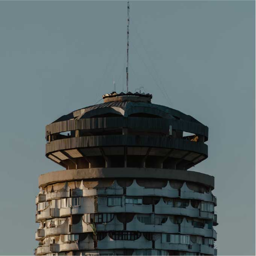

In [67]:
asc_image = Image.open(BytesIO(response.content)).resize((256, 256))
asc_image

## 2.2 Key Parameters in Convolution
***
The convolution operation is governed by several key parameters that affect the output dimensions and characteristics of the feature map. PyTorch provides a convenient way to implement convolutional layers using the `torch.nn.Conv2d` class. The key parameters include:

| Parameter | Description | Effect on Output Dimensions |
|-----------|-------------|---------------------------|
| **Kernel Size** | The dimensions of the filter (e.g., 3×3, 5×5) | Larger kernels reduce output size more |
| **Stride** | How many pixels the filter shifts at each step | Larger strides reduce output dimensions |
| **Padding** | Adding extra pixels around the border | Can preserve input dimensions |
| **Dilation** | Spacing between kernel elements | Increases receptive field without increasing parameters |

Understanding how these parameters affect the output dimensions is crucial for designing effective CNN architectures. The formula for calculating the output dimensions of a convolutional layer is:

$$\text{Output Size} = \left\lfloor\frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} + 1\right\rfloor$$

where $\lfloor \cdot \rfloor$ represents the floor operation (rounding down to the nearest integer).

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Note**: This formula assumes that both the input and kernel are square, but it can be applied separately to height and width for rectangular inputs and kernels.

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 1**: Implement a function that calculates the output dimensions of a convolutional layer given the input size, kernel size, stride, and padding.

In [68]:
# Exercise 1: Calculating Convolutional Output Dimensions
# Implement a function to calculate the output dimensions after applying convolution
# with different kernel sizes, strides, and padding values.

def calculate_output_size(input_height:int, input_width:int, 
                          kernel_size:int, stride:int=1, padding:int=0) -> tuple:
    """Calculate the output dimensions after applying convolution.
    
    Args:
        input_height (int): Height of the input feature map
        input_width (int): Width of the input feature map
        kernel_size (int): Size of the square kernel
        stride (int, optional): Convolution stride. Defaults to 1.
        padding (int, optional): Padding size. Defaults to 0.
        
    Returns:
        tuple: (output_height, output_width)
    """
    # Implement the formula for calculating output dimensions
    output_height = int((input_height - kernel_size + 2 * padding) / stride + 1) 
    output_width = int((input_width - kernel_size + 2 * padding) / stride + 1) 
    
    return output_height, output_width

In [69]:
# Test the function with different parameters
# Case 1: Standard convolution with a 3x3 kernel, stride=1, no padding
input1 = (28, 28)  # e.g., MNIST image size
output1 = calculate_output_size(input1[0], input1[1], kernel_size=3) # Your code here

# Case 2: Convolution with padding=1 to preserve dimensions
input2 = (224, 224)  # e.g., Standard ImageNet size
output2 = calculate_output_size(input2[0], input2[1], kernel_size=3, stride=1, padding=1) # Your code here

# Case 3: Convolution with stride=2 for downsampling
input3 = (128, 128)
output3 = calculate_output_size(input3[0], input3[1], kernel_size=5, stride=2, padding=2) # Your code here

# Case 4: Custom parameters
input4 = (64, 64)
output4 = calculate_output_size(input4[0], input4[1], kernel_size=7, stride=2, padding=3) # Your code here

print(f"Case 1: {input1} → {output1} (3x3 kernel, stride=1, no padding)")
print(f"Case 2: {input2} → {output2} (3x3 kernel, stride=1, padding=1)")
print(f"Case 3: {input3} → {output3} (5x5 kernel, stride=2, padding=2)")
print(f"Case 4: {input4} → {output4} (7x7 kernel, stride=2, padding=3)")

Case 1: (28, 28) → (26, 26) (3x3 kernel, stride=1, no padding)
Case 2: (224, 224) → (224, 224) (3x3 kernel, stride=1, padding=1)
Case 3: (128, 128) → (64, 64) (5x5 kernel, stride=2, padding=2)
Case 4: (64, 64) → (32, 32) (7x7 kernel, stride=2, padding=3)


## 2.3 What is a Filter?
***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="20"/> **Definition**: A filter (or kernel) is a small matrix used in convolutional operations to extract features from an image. It slides over the image, performing element-wise multiplication and summing the results to produce a single output value.

Filters allow CNNs to learn and detect specific patterns, such as edges, textures, and shapes, by adjusting their weights during training. The concept of filters is central to computer vision tasks, and there are existing filters for common tasks, such as edge detection and blurring. Let's explore some of these filters and their effects on images.

We are going to try the following filters:

| Filter | Kernel | Description |
|--------|--------|-------------|
| **Edge Detection** | $$\begin{bmatrix} 1 & 0 & -1 \\ 1 & 0 & -1 \\ 1 & 0 & -1 \end{bmatrix}$$ | Detects vertical edges |
| **Sharpening** | $$\begin{bmatrix} 0 & -1 & 0 \\ -1 & 5 & -1 \\ 0 & -1 & 0 \end{bmatrix}$$ | Enhances edges and details |
| **Embossing** | $$\begin{bmatrix} -2 & -1 & 0 \\ -1 & 1 & 1 \\ 0 & 1 & 2 \end{bmatrix}$$ | Creates a 3D effect |

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 2**: Implement the `apply_filter_pytorch` function and apply three classic filters (edge detection, sharpening, embossing) to a test image using PyTorch's `Conv2d`.

In [70]:
# Exercise 2: Designing Convolutional Filters with PyTorch
# In this exercise, you will implement common filters used in image processing using PyTorch

def apply_filter_pytorch(image, kernel):
    """Apply a convolutional filter to an image using PyTorch.
    
    Args:
        image (numpy.ndarray): Input image (grayscale or RGB)
        kernel (numpy.ndarray): Convolutional kernel/filter
        
    Returns:
        numpy.ndarray: Filtered image
    """
    # Make a copy of the image to avoid modifying the original
    image_copy = image.copy().astype(np.float32)
    
    # For RGB: rearrange to PyTorch format (B, C, H, W)
    image_tensor = torch.from_numpy(image_copy).permute(2, 0, 1).unsqueeze(0) 
    channels = image_copy.shape[2] 
    
    # Convert kernel to PyTorch tensor
    kernel_tensor = torch.from_numpy(kernel.astype(np.float32)).unsqueeze(0).unsqueeze(0) 
    
    # Create a convolutional layer with our kernel as weights
    # Use groups=channels to apply the same kernel to each channel independently
    conv_layer = torch.nn.Conv2d(in_channels=channels, 
                                 out_channels=channels,
                                 kernel_size=kernel.shape[0],
                                 bias=False,
                                 padding=kernel.shape[0]//2, 
                                 groups=channels)
    
    # Set the weights to our kernel
    with torch.no_grad():
        for i in range(channels):
            conv_layer.weight.data[i] = kernel_tensor
    
    # Apply convolution
    with torch.no_grad():
        filtered = conv_layer(image_tensor) # Your code here
    
    # Convert back to numpy array in correct format
    filtered_image = filtered.squeeze(0).permute(1, 2, 0).numpy() # Your code here
    
    # Clip values to be in valid range for images (0-255)
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8) # Your code here
    return filtered_image

In [71]:
# Design several common convolutional filters

# 1. Edge detection filter (should highlight boundaries between different regions)
edge_detection_kernel = np.array([
    [1, 0, -1],
    [0, 0, 0],
    [-1, 0, 1]
])

# 2. Sharpening filter (should enhance details by increasing contrast)
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

# 3. Embossing filter (should give a 3D effect by highlighting edges with shadows)
emboss_kernel = np.array([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]
])

# Load a test image - use the ascent image we loaded earlier
test_image = np.array(asc_image)

# Apply the filters to the test image using PyTorch
edge_detect_image = apply_filter_pytorch(test_image, edge_detection_kernel)
sharpened_image = apply_filter_pytorch(test_image, sharpen_kernel)
embossed_image = apply_filter_pytorch(test_image, emboss_kernel)

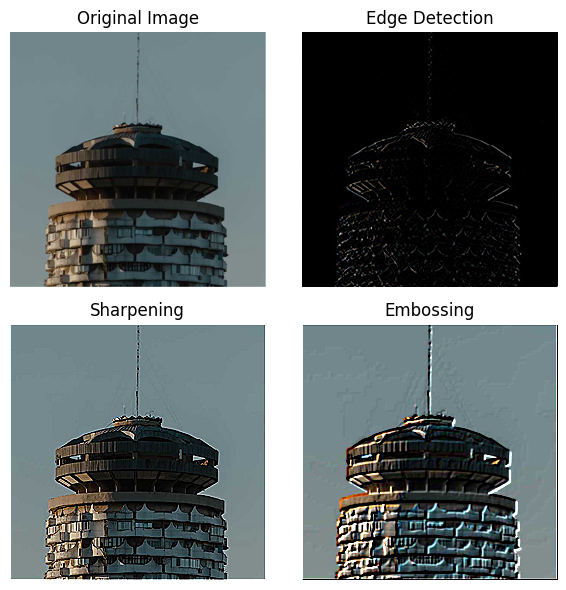

In [72]:
# Display the results
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].imshow(test_image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(edge_detect_image)
axes[0, 1].set_title("Edge Detection")
axes[0, 1].axis('off')

axes[1, 0].imshow(sharpened_image)
axes[1, 0].set_title("Sharpening")
axes[1, 0].axis('off')

axes[1, 1].imshow(embossed_image)
axes[1, 1].set_title("Embossing")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

Above we used predefined filters, but in practice, the filters are learned during training. The network learns to adjust the filter weights to detect relevant features for the specific task at hand.

Let's see how the output of a simple convolution operation looks like. 

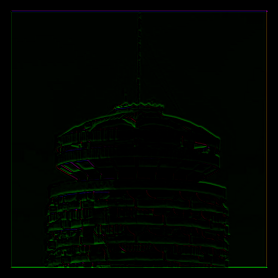

In [73]:
conv2d = torch.nn.Conv2d(
    in_channels=3, 
    out_channels=3, 
    kernel_size=3, 
    stride=1, 
    padding=12, 
)

torch.nn.init.xavier_uniform_(conv2d.weight)

# Change the shape of the image to (C, H, W)
torch_asc = torch.from_numpy(np.array(asc_image)).permute(2,0,1)
torch_asc = torch_asc.unsqueeze(0).float() # Add batch dimension

conv2d.eval()
filtered_asc = conv2d(torch_asc)
# Reverse the transformation to get back to (H, W, C)
filtered_asc = filtered_asc.squeeze(0).detach().numpy().transpose(1, 2, 0)

# Make sure the values are in the range [0, 255]
# and convert to uint8 for PIL
filtered_asc = np.clip(filtered_asc, 0, 255).astype(np.uint8) 
filtered_asc_img = Image.fromarray(filtered_asc)
filtered_asc_img

# <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="30"/> 3. Preparing image data
***
Since images can be seen as 3D tensors, we need to convert them into a format suitable for processing. In PyTorch, images are typically represented as 4D tensors with the shape `(batch_size, channels, height, width)`. For a single image, the shape would be `(1, 3, height, width)`.

To prepare the image data, we will use the `torchvision` library, which provides convenient functions for loading and transforming images. 

## 3.1 Torchvision transforms
***
Python uses `PIL` (Python Imaging Library) to handle images, and while `PIL` is great for basic image manipulation, it can be slow for large datasets. To speed up the process, we can use `torchvision.transforms`, which provides a set of common image transformations that can be applied to images in a more efficient way.

| Transform | PyTorch Function | Description |
|-----------|------------------|-------------|
| **Resize** | `transforms.Resize(size)` | Resizes the image to the specified size |
| **CenterCrop** | `transforms.CenterCrop(size)` | Crops the image at the center to the specified size |
| **RandomCrop** | `transforms.RandomCrop(size)` | Crops the image randomly to the specified size |
| **RandomHorizontalFlip** | `transforms.RandomHorizontalFlip(p)` | Flips the image horizontally with probability `p` |
| **RandomRotation** | `transforms.RandomRotation(degrees)` | Rotates the image randomly within the specified degrees |
| **Normalize** | `transforms.Normalize(mean, std)` | Normalizes the image tensor with the specified mean and standard deviation |
| **ColorJitter** | `transforms.ColorJitter(brightness, contrast, saturation, hue)` | Randomly changes the brightness, contrast, saturation, and hue of the image |
| **ToTensor** | `transforms.ToTensor()` | Converts the image to a PyTorch tensor |

These transformations can be combined to create a preprocessing pipeline that prepares the images for training. The `transforms.Compose` function allows us to chain multiple transformations together.

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Notes**:
> - Resizing is important because CNNs require fixed-size inputs.
> - The `ToTensor` transformation converts the image to a PyTorch tensor, and it also scales the pixel values to the range [0, 1]. 
> - Normalization is a common practice in deep learning to ensure that the input data has a mean of 0 and a standard deviation of 1. This helps the model converge faster during training.
***

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Snippet 1**: Composing transformations

```python
from torchvision import transforms

ts = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])
```

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 3**: Implement and visualize various image transformations — resize, crop, flip, rotation, colour jitter, and normalisation — using `torchvision.transforms.Compose`.

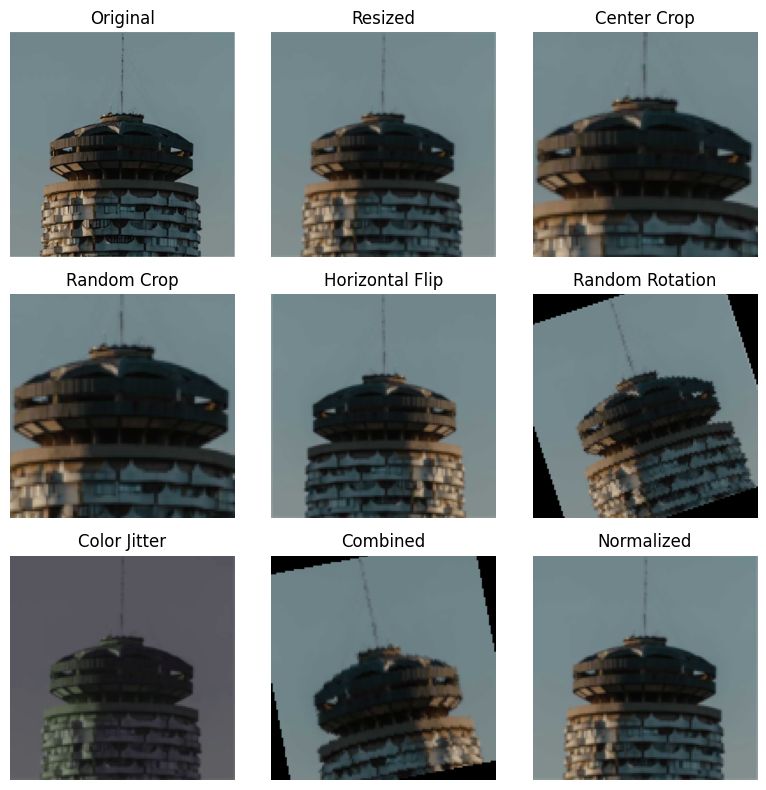

In [74]:
# Exercise 3: Implementing Image Transformations
# In this exercise, you will implement and visualize various image transformations
# commonly used in computer vision tasks

from torchvision import transforms


def apply_transformations(image_path):
    """Apply and visualize various image transformations.

    Args:
        image_path (str or Path): Path to the input image

    Returns:
        dict: Dictionary of transformed images
    """
    # Load the image
    img = Image.open(image_path) if isinstance(
        image_path, (str, Path)) else image_path

    # Define transformations
    # 1. Basic resize to 128x128 
    resize_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # 2. Center crop transformation
    center_crop_transform = transforms.Compose([
        transforms.Resize(150),  # Resize the smaller edge to 150 pixels
        transforms.CenterCrop(100),  # Crop a 100x100 square from the center
        transforms.ToTensor()
    ])

    # 3. Random crop transformation
    random_crop_transform = transforms.Compose([
        transforms.Resize(150),
        transforms.RandomCrop(100),
        transforms.ToTensor()
    ])

    # 4. Random horizontal flip transformation
    hflip_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        # 100% flip probability
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor()
    ])

    # 5. Random rotation transformation
    rotate_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        # Random rotation
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor()
    ])

    # 6. Color jitter transformation
    color_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5,
                               saturation=0.5, hue=0.3), 
        transforms.ToTensor()
    ])

    # 7. Combined transformations (practical data augmentation)
    combined_transform = transforms.Compose([
        transforms.Resize(150),
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])

    # 8. Normalization transformation
    norm_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    transforms_list = {
        'Original': transforms.ToTensor(),
        'Resized': resize_transform,
        'Center Crop': center_crop_transform,
        'Random Crop': random_crop_transform,
        'Horizontal Flip': hflip_transform,
        'Random Rotation': rotate_transform,
        'Color Jitter': color_transform,
        'Combined': combined_transform,
        'Normalized': norm_transform
    }

    # Apply transformations
    transforms_dict = {
        'Original': transforms.ToTensor()(img),
        'Resized': resize_transform(img),
        'Center Crop': center_crop_transform(img),
        'Random Crop': random_crop_transform(img),
        'Horizontal Flip': hflip_transform(img),
        'Random Rotation': rotate_transform(img),
        'Color Jitter': color_transform(img),
        'Combined': combined_transform(img),
        'Normalized': norm_transform(img)
    }

    return transforms_dict, transforms_list


# Apply transformations to an image and visualize the results
# Use the ascent image we loaded earlier as a test image
ts_dict, ts_list = apply_transformations(asc_image)
utils.plotting.se04_visualize_transformations(ts_dict)

## 3.2 NEU-CLS Surface Defect Dataset
***
In this session, we work with the **NEU-CLS** dataset (Surface Defect Classification), publicly released by the Surface Inspection Laboratory of Northeastern University. The dataset is collected from real industrial production lines and is designed for the automatic classification of strip surface defects.

The dataset contains **6 defect classes**, each with exactly **300 grayscale images** at a resolution of **200×200 pixels**:

| Class | Examples | Description |
|-------|----------|-------------|
| **Crazing** | 300 | Network of fine surface cracks |
| **Inclusion** | 300 | Foreign material embedded in the surface |
| **Patches** | 300 | Irregular patches on the surface |
| **Pitted Surface** | 300 | Small pits distributed across the surface |
| **Rolled-in Scale** | 300 | Oxide scale rolled into the surface during production |
| **Scratches** | 300 | Linear scratches on the surface |

***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Notes**:
> - Unlike the binary crack/no-crack task, this is a **6-class** multi-class classification problem.
> - All classes are **perfectly balanced** (300 images each) — no need for class balancing.
> - Images are **grayscale** (1 channel) — remember this when building the CNN input layer.

The dataset is distributed in **YOLO format** with  `images/` and `labels/` sub-folders. Since we only care about *classification* (not bounding box detection), we will read the class label from each annotation file and reorganise the images into the `ImageFolder`-compatible structure required by PyTorch.


In [75]:
data_path = Path.cwd() / "datasets"
dataset_path = utils.data.download_dataset("neu-cls",
                                            dest_path=data_path,
                                            extract=True,
                                            remove_compressed=True)
print(f"Dataset downloaded to: {dataset_path}")


Downloading:
NEU-CLS: Surface Defect Classification dataset from the Surface Inspection Laboratory of Northeastern University, covering 6 common strip surface defect types (Crazing, Inclusion, Patches, Pitted Surface, Rolled-in Scale, Scratches), 300 grayscale 200×200 images per class
> Authors: Surface Inspection Laboratory, Northeastern University
> Year: 2024
> Website: https://figshare.com/articles/dataset/NEU-CLS/28903550



Extracting NEU-CLS.zip: 100%|██████████| 3610/3610 [00:00<00:00, 6552.44it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/NEU-CLS.zip
Dataset downloaded to: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/NEU-CLS


In [76]:

import random as _random

# NEU-CLS class mapping (YOLO class id → folder name)
# These are sorted alphabetically, matching the order ImageFolder will assign indices.
NEU_CLASSES = {
    0: 'crazing',
    1: 'inclusion',
    2: 'patches',
    3: 'pitted_surface',
    4: 'rolled-in_scale',
    5: 'scratches'
}

def get_class_names(dataset_path):
    """Try to read class names from a data.yaml file; fall back to NEU_CLASSES."""
    yaml_files = list(dataset_path.rglob('data.yaml')) + list(dataset_path.rglob('*.yaml'))
    if yaml_files:
        try:
            import yaml
            with open(yaml_files[0], 'r') as f:
                cfg = yaml.safe_load(f)
            names = cfg.get('names', None)
            if names:
                if isinstance(names, list):
                    return {i: n.lower().replace(' ', '_') for i, n in enumerate(names)}
                return {int(k): v.lower().replace(' ', '_') for k, v in names.items()}
        except Exception:
            pass
    return NEU_CLASSES

def reorganize_yolo_to_imagefolder(dataset_path, output_path,
                                   train_ratio=0.70, val_ratio=0.15,
                                   seed=42):
    """
    Reorganise NEU-CLS from YOLO format into an ImageFolder-compatible structure
    with a proper *stratified* train / val / test split.

    Pools images from BOTH the YOLO 'train' and 'valid' directories so the ~30
    validation images are no longer the sole source of val/test data.

    Split (default): 70% train · 15% val · 15% test — per class.

    Returns:
        dict: mapping of class index → class name
    """
    dataset_path = Path(dataset_path)
    output_path  = Path(output_path)
    class_names  = get_class_names(dataset_path)

    # ------------------------------------------------------------------
    # 1. Collect every labelled image from all YOLO splits grouped by class
    # ------------------------------------------------------------------
    by_class: dict = {}
    for yolo_split in ('train/train', 'valid/valid'):
        img_dir = dataset_path / yolo_split / 'images'
        lbl_dir = dataset_path / yolo_split / 'labels'
        if not img_dir.exists():
            print(f"  Warning: {img_dir} not found — skipping.")
            continue
        for img_path in sorted(img_dir.glob('*.*')):
            lbl_path = lbl_dir / (img_path.stem + '.txt')
            if not lbl_path.exists():
                continue
            lines = [l.strip() for l in lbl_path.read_text().splitlines() if l.strip()]
            if not lines:
                continue
            class_id   = int(lines[0].split()[0])
            class_name = class_names.get(class_id, f'class_{class_id}')
            by_class.setdefault(class_name, []).append(img_path)

    # ------------------------------------------------------------------
    # 2. Stratified split: shuffle each class → 70 / 15 / 15
    # ------------------------------------------------------------------
    _random.seed(seed)
    train_count = val_count = test_count = 0

    for cls_name, imgs in by_class.items():
        _random.shuffle(imgs)
        n       = len(imgs)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)
        splits  = {
            'train': imgs[:n_train],
            'val':   imgs[n_train : n_train + n_val],
            'test':  imgs[n_train + n_val :],
        }
        for split_name, split_imgs in splits.items():
            dst = output_path / split_name / cls_name
            dst.mkdir(parents=True, exist_ok=True)
            for img_path in split_imgs:
                shutil.copy(img_path, dst / img_path.name)
        train_count += len(splits['train'])
        val_count   += len(splits['val'])
        test_count  += len(splits['test'])

    print(f"  Copied {train_count} images → {output_path / 'train'}")
    print(f"  Copied {val_count}   images → {output_path / 'val'}")
    print(f"  Copied {test_count}  images → {output_path / 'test'}")
    return class_names

# ── Run the reorganisation ──────────────────────────────────────────────────
# Force re-creation so the new stratified split always takes effect.
clf_data_path = data_path / 'neu_cls_imagefolder'

if clf_data_path.exists():
    print("Removing old ImageFolder structure to rebuild with proper 70/15/15 split …")
    shutil.rmtree(clf_data_path)

print("Reorganising dataset with stratified 70 / 15 / 15 split …")
class_names_map = reorganize_yolo_to_imagefolder(dataset_path, clf_data_path)

train_folder = clf_data_path / 'train'
val_folder   = clf_data_path / 'val'
test_folder  = clf_data_path / 'test'

print(f"\nClasses : {list(class_names_map.values())}")
print(f"Train   : {sum(1 for _ in train_folder.rglob('*.*') if _.is_file())} images")
print(f"Val     : {sum(1 for _ in val_folder.rglob('*.*')   if _.is_file())} images")
print(f"Test    : {sum(1 for _ in test_folder.rglob('*.*')  if _.is_file())} images")


Reorganising dataset with stratified 70 / 15 / 15 split …
  Copied 1260 images → /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/neu_cls_imagefolder/train
  Copied 270   images → /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/neu_cls_imagefolder/val
  Copied 270  images → /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/neu_cls_imagefolder/test

Classes : ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Train   : 1260 images
Val     : 270 images
Test    : 270 images


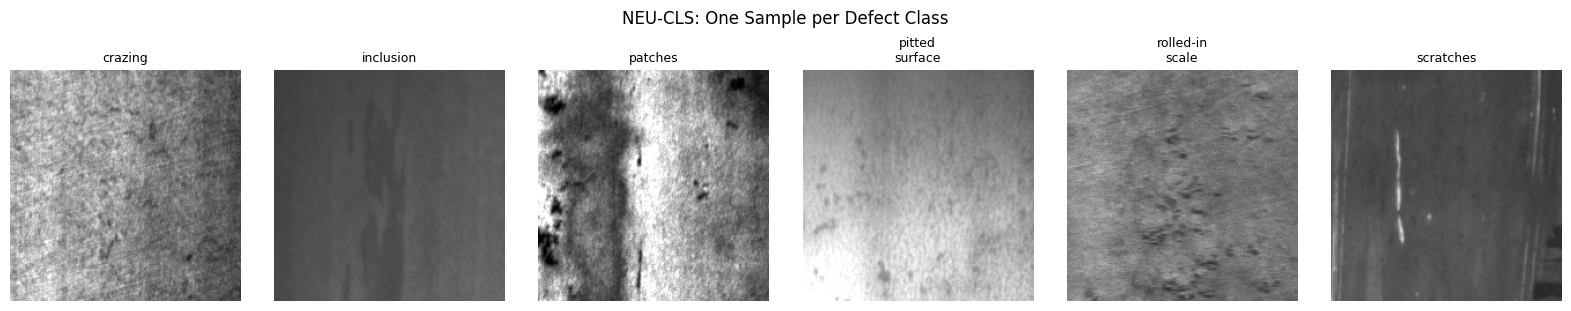

Image size : (200, 200)  (W × H)
Image mode : RGB
Classes    : ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [77]:
# Display one sample image from each defect class
class_dirs = sorted([d for d in train_folder.iterdir() if d.is_dir()])
fig, axes = plt.subplots(1, len(class_dirs), figsize=(16, 3))
for ax, cls_dir in zip(axes, class_dirs):
    img_files = list(cls_dir.glob('*.*'))
    if img_files:
        img = Image.open(img_files[0])
        ax.imshow(img, cmap='gray')
        ax.set_title(cls_dir.name.replace('_', '\n'), fontsize=9)
        ax.axis('off')

plt.suptitle('NEU-CLS: One Sample per Defect Class', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Display image shape information
sample_img = Image.open(img_files[0])
print(f"Image size : {sample_img.size}  (W × H)")
print(f"Image mode : {sample_img.mode}")
print(f"Classes    : {[d.name for d in class_dirs]}")


## 3.3 PyTorch ImageFolder
***
While we can load images using `PIL`, PyTorch provides a more efficient way to handle large datasets through the `torchvision.datasets` module. This module contains the `ImageFolder` class, which allows us to load images from a directory structure where each subdirectory represents a class. The `ImageFolder` class automatically assigns labels based on the subdirectory names.

The `ImageFolder` class requires a root directory containing subdirectories for each class. The directory structure — which we just created — looks like this:

```bash
neu_cls_imagefolder/
    ├── train/
    │   ├── crazing/         ← class 0
    │   ├── inclusion/       ← class 1
    │   ├── patches/         ← class 2
    │   ├── pitted_surface/  ← class 3
    │   ├── rolled-in_scale/ ← class 4
    │   └── scratches/       ← class 5
    ├── val/
    │   └── (same 6 sub-folders)
    └── test/
        └── (same 6 sub-folders)
```

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Important**: `ImageFolder` sorts class sub-folders **alphabetically** and assigns integer labels accordingly (0, 1, 2, …). This is why the `NEU_CLASSES` dictionary we built in the previous cell was sorted to match.

The key parameters of the `ImageFolder` class are:

| Parameter | Description |
|-----------|-------------|
| **root** | The root directory containing the dataset |
| **transform** | A function/transform to apply to the images |
| **target_transform** | A function/transform to apply to the target (label) |
| **loader** | A function to load the images (default is `PIL.Image.open`) |
| **is_valid_file** | A function to check if a file is valid (default is `None`) |

***

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Snippet 2**: Using ImageFolder

```python
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root='path/to/dataset', transform=ts)
# Accessing the first image and its label
image, label = dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")
print(f"Classes: {dataset.classes}")
```

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 4**: Define data augmentation transforms for the training set and minimal transforms for validation/test, then load the NEU-CLS dataset splits using `ImageFolder`.

In [78]:

# Exercise 4: Data Augmentation and Loading with PyTorch
# Implement:
# 1. Data augmentation transforms for the NEU-CLS training set
# 2. Minimal transforms for validation and test sets
# 3. Load datasets using ImageFolder

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Training transforms — include data augmentation for better generalisation.
# ⚠️  The images are GRAYSCALE (1 channel). Use transforms.Grayscale(num_output_channels=1)
#     to guarantee a single-channel tensor regardless of how PIL opened the file.
ts_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure 1 channel
    transforms.Resize((128, 128)),                # larger size for more detail
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),                        # scales pixel values to [0, 1]
])

# Validation / test transforms — no augmentation, just resize and convert.
ts_test_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets using ImageFolder
train_data = ImageFolder(root=train_folder, transform=ts_train)
val_data   = ImageFolder(root=val_folder,   transform=ts_test_val)
test_data  = ImageFolder(root=test_folder,  transform=ts_test_val)

print(f"Classes ({len(train_data.classes)}): {train_data.classes}")
print(f"Train samples : {len(train_data)}")
print(f"Val   samples : {len(val_data)}")
print(f"Test  samples : {len(test_data)}")

# Sample tensor to verify shape — should be (1, 128, 128) for a grayscale image
sample_img, sample_lbl = train_data[0]
print(f"\nSample tensor shape : {sample_img.shape}  (C × H × W)")
print(f"Sample label        : {sample_lbl}  ({train_data.classes[sample_lbl]})")

Classes (6): ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Train samples : 1260
Val   samples : 270
Test  samples : 270

Sample tensor shape : torch.Size([1, 128, 128])  (C × H × W)
Sample label        : 0  (crazing)


## 3.4 PyTorch DataLoaders
***
As we discussed in the previous session, when training a model we need to load the data in batches. PyTorch provides the `DataLoader` class to handle this efficiently. The `DataLoader` class takes a dataset and provides an iterable over the dataset, allowing us to load data in batches.

The model expects our image data to be formatted as a 4D tensor with the shape `(batch_size, channels, height, width)`.

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/image_batches.png" width="70%">
</div>

The `DataLoader` class provides several key parameters to customize the data loading process:

| Parameter | Description |
|-----------|-------------|
| **dataset** | The dataset to load data from (e.g., `ImageFolder`) |
| **batch_size** | The number of samples per batch |
| **shuffle** | Whether to shuffle the data at every epoch |
| **num_workers** | The number of subprocesses to use for data loading |
| **pin_memory** | Whether to pin memory for faster data transfer to GPU |
| **drop_last** | Whether to drop the last incomplete batch |

***

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Snippet 3**: Creating a DataLoader

```python
from torch.utils.data import DataLoader

# Create a DataLoader for the dataset
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
# Iterate through the DataLoader
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}, Labels: {labels}")
    break  # Just to show the first batch
```

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 5**: Wrap the three `ImageFolder` datasets in `DataLoader` objects, using `shuffle=True` for training and `shuffle=False` for validation and test.

In [79]:
# Exercise 5: DataLoader
# Wrap the three ImageFolder datasets in DataLoaders.
# Use shuffle=True for training and shuffle=False for validation/test.
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
test_dl  = DataLoader(test_data,  batch_size=32, shuffle=False)
val_dl   = DataLoader(val_data,   batch_size=32, shuffle=False)

# Inspect one batch to confirm shape: (batch_size, channels, height, width)
imgs, lbls = next(iter(train_dl))
print(f"Batch shape : {imgs.shape}  — (N, C, H, W)")
print(f"Labels      : {lbls[:8].tolist()}")

Batch shape : torch.Size([32, 1, 128, 128])  — (N, C, H, W)
Labels      : [3, 3, 0, 0, 2, 1, 4, 4]



# <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="30"/> 4. Implementing CNNs
***
The architecture of a CNN is not that different from a standard neural network. The main difference is that CNNs use convolutional layers instead of fully connected layers. This means that after each convolutional layer, we typically apply a non-linear activation function (like ReLU). 

The output of the CNN is then passed through one or more fully connected layers to produce the final output. Thus, we need to keep track of the output size after each layer to ensure that the dimensions match up correctly.

A diagram of a conventional CNN architecture is shown below.

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/cnn.png" width="90%">
</div>

We are going to implement a simple CNN architecture for the NEU-CLS surface defect classification task. The architecture consists of the following layers:

| Type | Layer | Input Size | Output Size | Activation Function |
|-------|-------|------------|-------------|---------------------|
| Convolution | `Conv2d` | `(1, 128, 128)` | `(16, 128, 128)` | ReLU |
| Pooling | `MaxPool2d` | `(16, 128, 128)` | `(16, 64, 64)` | — |
| Convolution | `Conv2d` | `(16, 64, 64)` | `(16, 64, 64)` | ReLU |
| Fully Connected | `Linear` | `(16 × 64 × 64)` | `32` | ReLU |
| Fully Connected | `Linear` | `32` | `6` | None |

***
<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/cnn_02.png" width="90%">
</div>

***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Note**: The input has **1 channel** (grayscale) and the output has **6 neurons** (one per defect class). The `MaxPool2d(2×2)` layer halves the spatial dimensions after the first convolution, keeping the fully-connected head manageable while capturing larger receptive fields.

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 6**: Implement the `simpleCNN` class with one convolutional layer, max-pooling, and two fully-connected layers for 6-class surface defect classification.

In [92]:

# Exercise 6: Implementing a Simple CNN Model
# Build a minimal CNN for 6-class surface defect classification.
# Key differences from a typical RGB model:
#   • in_channels = 1   (grayscale images)
#   • n_classes   = 6   (six defect types)

class simpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super(simpleCNN, self).__init__()
        # Conv layer: 1 input channel → 16 feature maps, kernel 3×3, same padding
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)

        # MaxPool 2×2: halves spatial size → 128×128 → 64×64
        self.pool  = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv layer 2 after pool: 16 feature maps → 16 feature maps, kernel 3×3, same padding
        self.conv2 = torch.nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)


        # After conv2: feature map is 64×64
        # Flatten → 16 × 64 × 64 = 65 536 values
        self.fc1 = torch.nn.Linear(16 * 64 * 64, 32)
        self.fc2 = torch.nn.Linear(32, n_classes)   # output: 6 logits

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = torch.nn.functional.relu(self.conv2(x))
        x = x.view(-1, 16 * 64 * 64)       # flatten
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_v1 = simpleCNN(len(train_data.classes))
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_v1.parameters(), lr=3e-3)
num_epochs = 30

print(model_v1)
print(f"\nOutput classes : {len(train_data.classes)}")

simpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=6, bias=True)
)

Output classes : 6


simpleCNN Training:   0%|          | 0/30 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

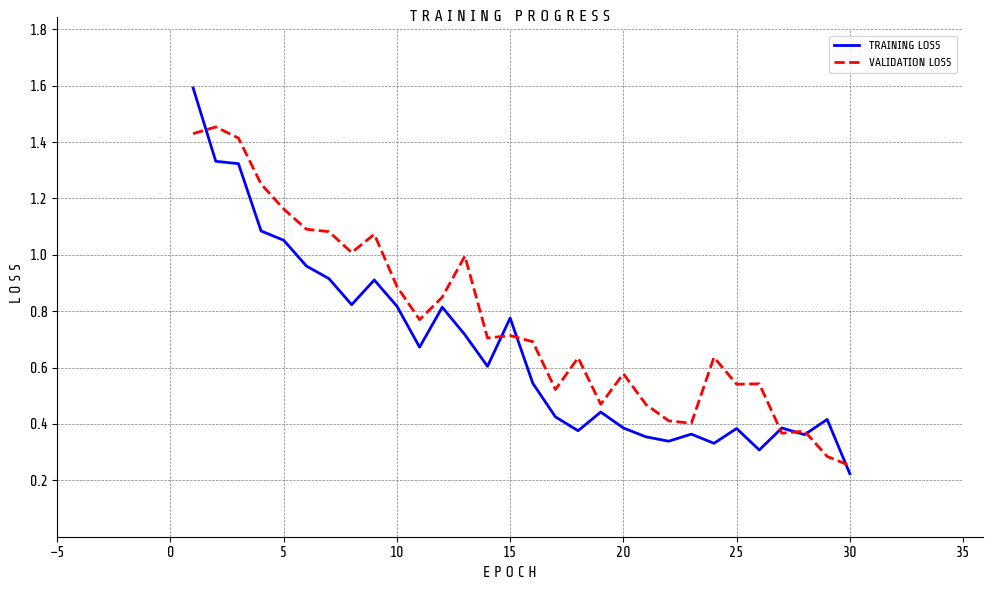

In [93]:
model_v1 = utils.ml.train_model(model_v1,
                                criterion,
                                optimiser,
                                train_loader=train_dl,
                                val_loader=val_dl,
                                num_epochs=num_epochs,
                                plot_loss=True)


## 4.1 Getting Predictions
***
The output of the last **fully-connected** layer gives us raw **logits** — one per class (six in our case). To obtain a predicted class label we take the index of the highest logit using `torch.argmax` (or equivalently `torch.max(..., dim=1)`).

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Note**: PyTorch's `CrossEntropyLoss` applies softmax internally, so we do **not** add a softmax layer at the end of the model during training. For inference we also skip softmax when we only need the predicted label (we just pick the maximum logit).

***

> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Snippet 4**: Obtaining the predicted class

```python
model_v1.eval()

with torch.no_grad():
    for images, labels in test_dl:
        outputs = model_v1(images)   # (batch, 6) logits
        _, predicted = torch.max(outputs, dim=1)
        print("Logits shape:", outputs.shape)
        print("Predictions :", predicted[:8].tolist())
        print("True labels :", labels[:8].tolist())
        break
```

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 7**: Compute the test accuracy and classification report for the simple CNN model.

In [95]:
# Exercise 7: Evaluating the Simple CNN
acc = utils.ml.compute_accuracy(model_v1, test_dl)
print(f"Test accuracy: {acc * 100:.2f}%")

cls_report = utils.ml.compute_classification_report(
    model_v1, test_dl, class_names=train_data.classes
)
print('-' * 60)
print(f"Classification Report:\n{cls_report}")

Test accuracy: 92.59%
------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

        crazing       0.97      0.82      0.89        45
      inclusion       0.93      0.93      0.93        45
        patches       0.88      0.93      0.90        45
 pitted_surface       0.83      0.96      0.89        45
rolled-in_scale       0.98      0.98      0.98        45
      scratches       1.00      0.93      0.97        45

       accuracy                           0.93       270
      macro avg       0.93      0.93      0.93       270
   weighted avg       0.93      0.93      0.93       270



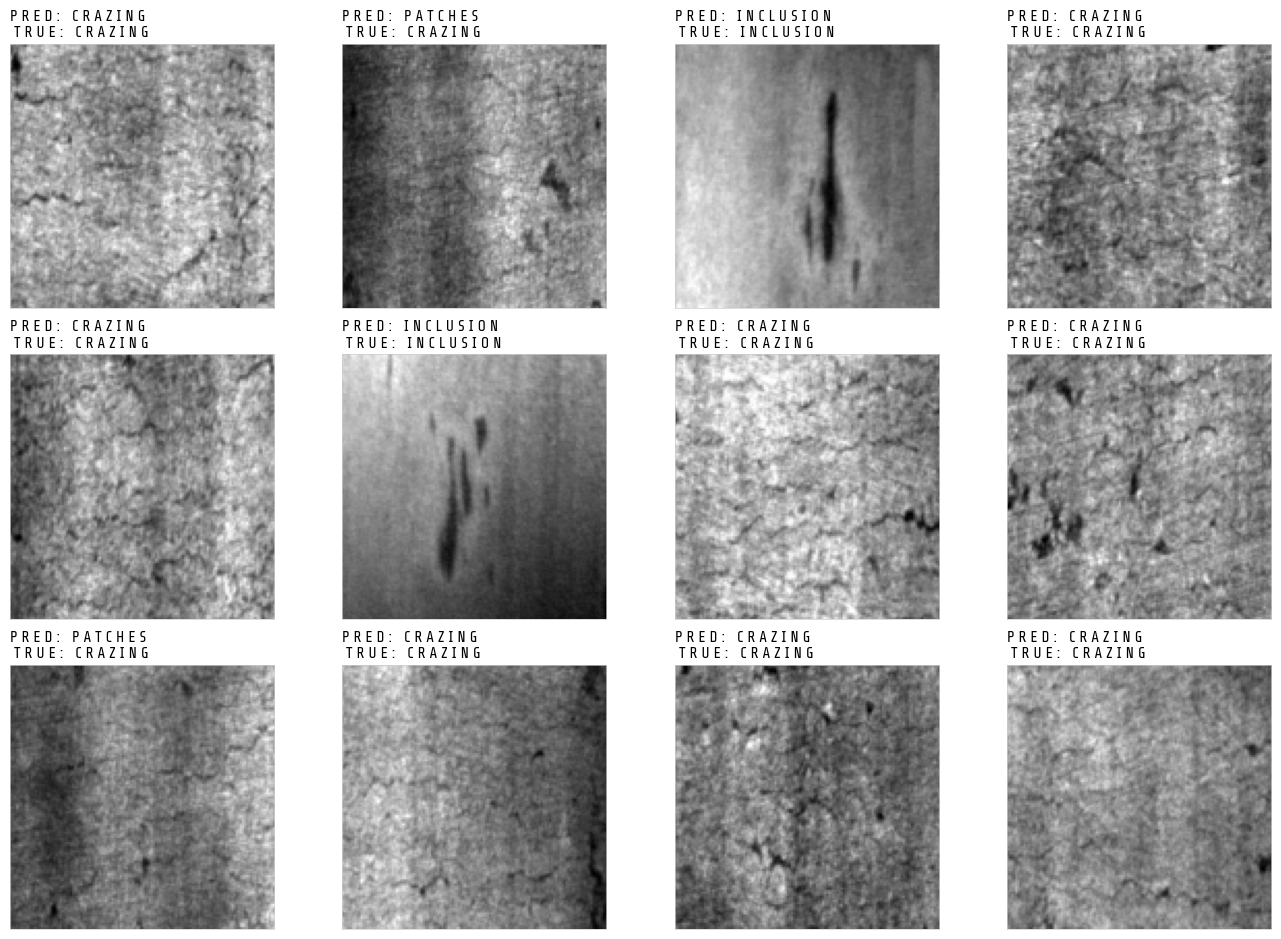

Displayed samples: 10/12 correct (83.3%)


In [96]:
# Visualize the model predictions
utils.plotting.show_model_predictions(model_v1, test_dl, class_names=train_data.classes)


## 4.2 Building MobileNet from Scratch
***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/write.svg" width="20"/> **Definition**: MobileNet is a lightweight CNN architecture designed for mobile and embedded vision applications, introduced by Google in 2017. Its key innovation is replacing standard convolutions with **depthwise separable convolutions**, dramatically reducing the number of parameters and computations without sacrificing accuracy.

### Why MobileNet?

Standard convolutions combine spatial filtering and channel mixing in one expensive step. MobileNet splits this into two cheaper operations:

| Operation | What it does | Parameters |
|-----------|-------------|-----------|
| **Depthwise Conv** (`groups=in_channels`) | Applies one filter per input channel independently | $K \times K \times C_{in}$ |
| **Pointwise Conv** (1×1 Conv) | Mixes the channel information | $C_{in} \times C_{out}$ |

The computational saving ratio vs a standard convolution is approximately:

$$\frac{1}{C_{out}} + \frac{1}{K^2}$$

For $K=3$, $C_{out}=64$: the depthwise separable block uses **~9× fewer operations**!

### 4.3 Depthwise Separable Convolution — The Building Block
***
Each MobileNet block consists of:

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/depthwise_conv.png" width="60%">
</div>

***
```
Input
  │
  ▼
┌─────────────────────────────────────┐
│  Depthwise Conv2d (groups=in_ch)    │   ← One spatial filter per channel
│  BatchNorm2d  →  ReLU               │
├─────────────────────────────────────┤
│  Pointwise Conv2d (kernel=1×1)      │   ← Recombines channels
│  BatchNorm2d  →  ReLU               │
└─────────────────────────────────────┘
  │
  ▼
Output
```



### 4.4 Our MobileNet Architecture
***
We build a miniaturised MobileNetV1 for 128×128 grayscale inputs. The initial stride-2 convolution and three stride-2 depthwise blocks progressively halve the spatial size while the number of channels grows:

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/mobilenet.png" width="90%">
</div>

***

| Stage | Layer | Output Shape | Notes |
|-------|-------|-------------|-------|
| Entry | Conv2d (stride 2) | 64×64×32 | Standard conv |
| DS Block 1 | DW+PW (stride 1) | 64×64×64 | |
| DS Block 2 | DW+PW (stride 2) | 32×32×128 | ↓ spatial |
| DS Block 3 | DW+PW (stride 1) | 32×32×128 | |
| DS Block 4 | DW+PW (stride 2) | 16×16×256 | ↓ spatial |
| DS Block 5 | DW+PW (stride 1) | 16×16×256 | |
| GAP | AdaptiveAvgPool2d(1) | 1×1×256 | Global Average Pool |
| Classifier | Linear + Dropout | 6 | One logit per class |

***
> <img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/reminder.svg" width="20"/> **Key Pattern**: Use `groups=in_channels` in `torch.nn.Conv2d` to create a **depthwise** convolution. Then follow it with a **1×1** `Conv2d` (pointwise) to recombine channels. This pair is what gives MobileNet its efficiency.

### 4.5 Regularisation in MobileNet
***
MobileNet uses two main regularisation strategies:

| Technique | PyTorch | Purpose |
|-----------|---------|---------|
| **Batch Normalisation** | `torch.nn.BatchNorm2d` | Stabilises training, acts as a mild regulariser |
| **Dropout** | `torch.nn.Dropout(p)` | Prevents over-reliance on individual features in the classifier |

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 8**: Implement `DepthwiseSeparableConv` and `MobileNetV1` from scratch, using depthwise separable convolutions with batch normalisation and global average pooling.

In [ ]:

# Exercise 8: Implementing MobileNet from Scratch
# Build a MobileNetV1-inspired architecture using depthwise separable convolutions.
#
# Steps:
#  1. Define a reusable DepthwiseSeparableConv block (DW conv + PW conv)
#  2. Stack several blocks with increasing channels and strategic stride=2 for downsampling
#  3. Replace the Flatten+Linear head with Global Average Pooling (AdaptiveAvgPool2d)

class DepthwiseSeparableConv(torch.nn.Module):
    """
    One MobileNet building block:
      Depthwise Conv (groups=in_channels) → BN → ReLU
      Pointwise Conv (kernel=1×1)         → BN → ReLU
    """
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        # --- Depthwise: one spatial filter per input channel ----------------
        self.depthwise = torch.nn.Conv2d(
            in_channels,
            in_channels,          # same number of filters as input channels
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,   # ← this makes it depthwise!
            bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(in_channels)

        # --- Pointwise: 1×1 conv to mix channels ----------------------------
        self.pointwise = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=False
        )
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.depthwise(x)))
        x = torch.nn.functional.relu(self.bn2(self.pointwise(x)))
        return x


class MobileNetV1(torch.nn.Module):
    """
    Lightweight MobileNetV1-inspired model for 6-class surface defect classification.
    
    Input:  (N, 1, 128, 128)   — grayscale images
    Output: (N, n_classes)     — raw logits
    """
    def __init__(self, n_classes: int, in_channels: int = 1):
        super().__init__()

        # --- Entry convolution (standard, stride=2 to halve spatial size) ---
        self.entry_conv = torch.nn.Conv2d(
            in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False
        )
        self.entry_bn = torch.nn.BatchNorm2d(32)

        # --- Depthwise Separable blocks -------------------------------------
        # Each line: DepthwiseSeparableConv(in_ch, out_ch, stride)
        # stride=2 halves spatial dimensions; stride=1 keeps them the same.
        # Spatial sizes below assume 128×128 input → 64×64 after entry conv
        self.blocks = torch.nn.Sequential(
            DepthwiseSeparableConv(32,  64,  stride=1),   # 64×64 → 64×64
            DepthwiseSeparableConv(64,  128, stride=2),   # 64×64 → 32×32
            DepthwiseSeparableConv(128, 128, stride=1),   # 32×32 → 32×32
            DepthwiseSeparableConv(128, 256, stride=2),   # 32×32 → 16×16
            DepthwiseSeparableConv(256, 256, stride=1),   # 16×16 → 16×16
        )

        # --- Classifier head ------------------------------------------------
        # Global Average Pooling collapses each feature map to a single value,
        # giving a fixed-size vector regardless of spatial input size.
        self.gap     = torch.nn.AdaptiveAvgPool2d((1, 1))   # → (N, 256, 1, 1)
        self.flatten = torch.nn.Flatten()                    # → (N, 256)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.fc      = torch.nn.Linear(256, n_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.entry_bn(self.entry_conv(x)))
        x = self.blocks(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Instantiate and inspect the model
model_v2 = MobileNetV1(n_classes=len(train_data.classes))
print(model_v2)

# Count parameters
total_params = sum(p.numel() for p in model_v2.parameters() if p.requires_grad)
print(f"\nTrainable parameters: {total_params:,}")


MobileNetV1(
  (entry_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (entry_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momen

In [ ]:
model_v2 = MobileNetV1(n_classes=len(train_data.classes))

criterion_reg = torch.nn.CrossEntropyLoss()
optimiser_reg = torch.optim.AdamW(
    model_v2.parameters(),
    lr=1e-3,
    weight_decay=1e-4,   # L2 regularisation (weight decay)
)
num_epochs_reg = 30

# Reduce learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser_reg,
    mode='min',
    factor=0.5,
    patience=3,
)


MobileNetV1 Training:   0%|          | 0/30 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/40:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Best model saved at /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/my_models/se04_mobilenet.pt


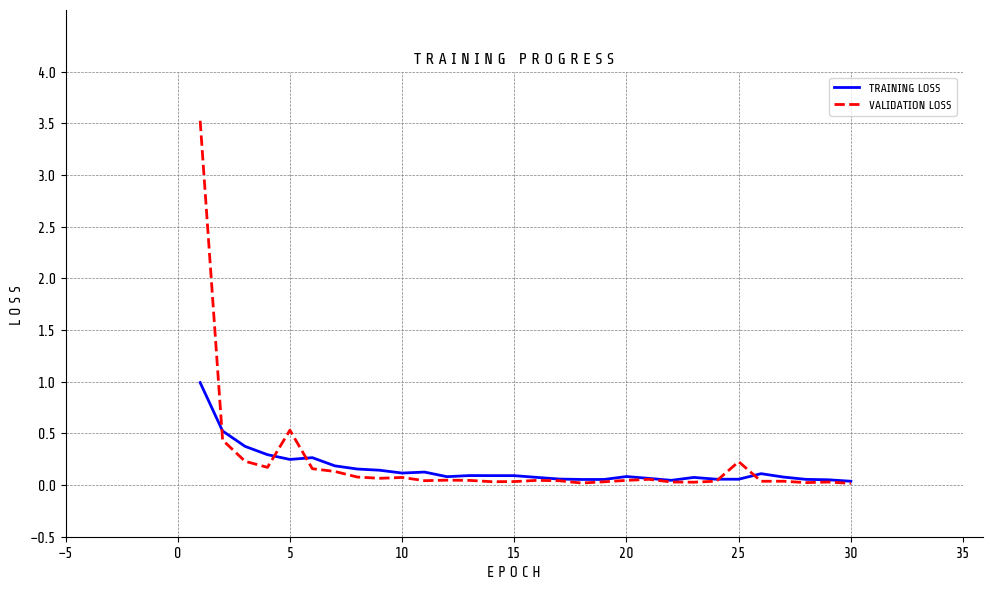

In [ ]:
model_v2 = utils.ml.train_model(model_v2,
                  criterion_reg,
                  optimiser_reg,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs_reg,
                  early_stopping=True,
                  patience=5,
                  tolerance=1e-2,
                  save_path=Path.cwd() / "my_models" / "se04_mobilenet.pt",
                  plot_loss=True)


In [ ]:
# Load the best model checkpoint saved during training
model_v2.load_state_dict(torch.load(Path.cwd() / "my_models" / "se04_mobilenet.pt"))
print("Best MobileNet model loaded.")


Best MobileNet model loaded.


## 4.6 Evaluating the MobileNet
***
Now that the MobileNet has been trained, let's evaluate its performance on the test set and compare it with the simple CNN.

<img src="https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/figs/icons/code.svg" width="20"/> **Exercise 9**: Compute the test accuracy and full classification report for the trained MobileNet model.

In [ ]:
# Exercise 9: Evaluating the MobileNet
acc = utils.ml.compute_accuracy(model_v2, test_dl)
print(f"Test accuracy: {acc * 100:.2f}%")

cls_report = utils.ml.compute_classification_report(
    model_v2, test_dl, class_names=train_data.classes
)
print('-' * 60)
print(f"Classification Report:\n{cls_report}")

Test accuracy: 99.26%
------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00        45
      inclusion       0.96      1.00      0.98        45
        patches       1.00      1.00      1.00        45
 pitted_surface       1.00      0.96      0.98        45
rolled-in_scale       1.00      1.00      1.00        45
      scratches       1.00      1.00      1.00        45

       accuracy                           0.99       270
      macro avg       0.99      0.99      0.99       270
   weighted avg       0.99      0.99      0.99       270

--------------------------------------------------------------------------------
✅ test_accuracy is correct!
✅ classification_report is correct!

🎉 Excellent! All parts are correct!


In [ ]:

# 🔍 Overfitting Diagnostic: Train / Val / Test accuracy comparison
# A well-generalising model shows small gaps between all three splits.
# A large train - test gap is the tell-tale sign of overfitting.

train_acc = utils.ml.compute_accuracy(model_v2, train_dl)
val_acc   = utils.ml.compute_accuracy(model_v2, val_dl)
test_acc  = utils.ml.compute_accuracy(model_v2, test_dl)

print(f"{'Split':<10} {'Accuracy':>10}")
print("-" * 22)
print(f"{'Train':<10} {train_acc * 100:>9.2f}%")
print(f"{'Val':<10} {val_acc   * 100:>9.2f}%")
print(f"{'Test':<10} {test_acc  * 100:>9.2f}%")
print("-" * 22)
gap = (train_acc - test_acc) * 100
print(f"\nTrain → Test gap : {gap:.2f} pp")
if gap < 5:
    print("✅ Gap < 5 pp — model generalises well, no significant overfitting.")
elif gap < 10:
    print("⚠️  Gap 5–10 pp — mild overfitting; consider more augmentation or stronger dropout.")
else:
    print("❌  Gap > 10 pp — clear overfitting; reduce model capacity or add regularisation.")


Split        Accuracy
----------------------
Train          99.92%
Val            99.63%
Test           99.26%
----------------------

Train → Test gap : 0.66 pp
✅ Gap < 5 pp — model generalises well, no significant overfitting.


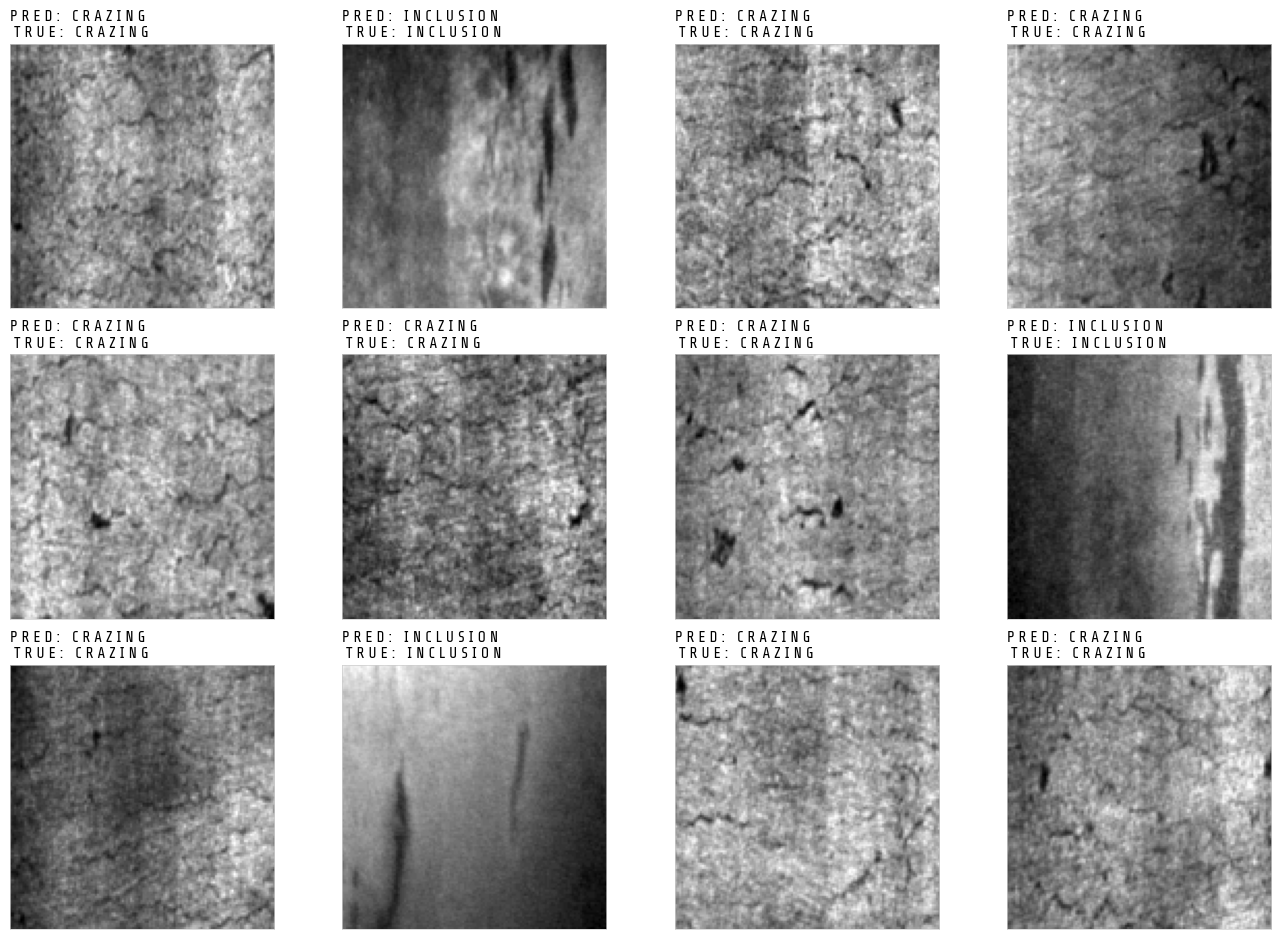

Displayed samples: 12/12 correct (100.0%)


In [ ]:
utils.plotting.show_model_predictions(model_v2, test_dl, class_names=train_data.classes, num_images=12)